# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

## ⚠️ AI-Generated Content Notice

This notebook was automatically generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results and validate important findings independently.

## Overview

This Dandiset contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor area (M1) of rhesus macaques during resting and arm-reaching tasks. The study examines neural activity patterns in these motor cortices using one-photon calcium imaging with miniature microscopes, providing insights into motor control in both healthy conditions and movement disorders.

The researchers implanted gradient index (GRIN) lenses and expressed GCaMP6f to image calcium transients from genetically identified projection neurons in the deep layers of SMA and M1. The data captures neural activity patterns while the animals were at rest or performing an arm reaching task, enabling analysis of synchronous activity between neuron pairs and sequential activation patterns.

View this dataset on Neurosift: [https://neurosift.app/dandiset/001174/001174](https://neurosift.app/dandiset/001174/001174)

## What this notebook covers

This notebook demonstrates how to:

1. Access and browse the Dandiset using the DANDI API
2. Load and examine metadata from an NWB file containing calcium imaging data
3. Visualize calcium imaging data, including:
   - Raw image frames
   - ROI (Region of Interest) masks
   - Fluorescence traces from identified neurons
   - Event amplitudes from calcium transients
4. Analyze relationships between neural activity and explore patterns across neurons

We'll focus on a recording from subject Q during an arm-reaching task to demonstrate the analysis workflow.

## Required packages

The following packages are needed to run this notebook. We assume these are already installed in your environment.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import h5py
import remfile
import pynwb

# Set up plotting aesthetics
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)

## Loading the Dandiset

First, we'll connect to the DANDI archive and list the assets available in Dandiset 001174.

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")
assets = list(dandiset.get_assets())

print(f"Found {len(assets)} assets in the dataset")

# Get basic info about the dandiset
metadata = dandiset.get_metadata()
print(f"\nDandiset name: {metadata.name}")
print(f"Dandiset description: {metadata.description[:200]}...")

print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path} ({asset.size / 1e9:.1f} GB)")

Found 45 assets in the dataset

Dandiset name: Calcium imaging in SMA and M1 of macaques
Dandiset description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscop...

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb (10.7 GB)
- sub-Q/sub-Q_ophys.nwb (0.8 GB)
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (0.8 GB)
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (1.7 GB)
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (1.6 GB)


## Exploring a specific NWB file

For this example, we'll focus on a calcium imaging session from subject Q during an arm reaching task. Let's load the NWB file for session 20220915T133954.

In [3]:
# Find the specific asset we're interested in
target_path = "sub-Q/sub-Q_ses-20220915T133954_ophys.nwb"
target_asset = None

for asset in assets:
    if asset.path == target_path:
        target_asset = asset
        break

if target_asset:
    print(f"Found target asset: {target_asset.path}")
    print(f"Asset ID: {target_asset.identifier}")
    print(f"Asset size: {target_asset.size / 1e6:.1f} MB")
else:
    print("Target asset not found")

Found target asset: sub-Q/sub-Q_ses-20220915T133954_ophys.nwb
Asset ID: 807851a7-ad52-4505-84ee-3b155a5bd2a3
Asset size: 1178.3 MB


Now we'll load the NWB file using the asset URL. We'll use remote file access to avoid downloading the entire file.

In [4]:
# Load the NWB file from the DANDI archive
# We'll use the direct URL from our earlier exploration
url = "https://api.dandiarchive.org/api/assets/807851a7-ad52-4505-84ee-3b155a5bd2a3/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

Let's examine the basic metadata about this recording session.

In [5]:
# Display basic session information
print(f"Session ID: {nwb.identifier}")
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"File created: {nwb.file_create_date[0]}")
print()

# Subject information
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Sex: {nwb.subject.sex}")
print(f"Age: {nwb.subject.age}")

Session ID: a7bd67d8-614c-42aa-b07f-3ffd4b164e32
Session description: Calcium imaging in SMA during the arm reaching condition
Session start time: 2022-09-15 13:39:54.612000+00:00
File created: 2025-01-23 15:37:55.123079+00:00

Subject ID: Q
Species: Macaca mulatta
Sex: F
Age: P5Y


## Exploring the imaging data

This file contains one-photon calcium imaging data. First, let's look at the properties of the imaging device and setup.

In [6]:
# Imaging device information
device = nwb.devices["Miniscope"]
print(f"Imaging device: {device.description} (Manufacturer: {device.manufacturer})")

# Imaging plane information
imaging_plane = nwb.imaging_planes["ImagingPlane"]
print(f"\nImaging plane description: {imaging_plane.description}")
print(f"Excitation wavelength: {imaging_plane.excitation_lambda} nm")
print(f"Imaging rate: {imaging_plane.imaging_rate} Hz")
print(f"Indicator: {imaging_plane.indicator}")
print(f"Location: {imaging_plane.location}")

Imaging device: NVista3 (Manufacturer: Inscopix, Inc.)

Imaging plane description: The plane being imaged by the miniscope
Excitation wavelength: 475.0 nm
Imaging rate: 10.0 Hz
Indicator: N/A
Location: N/A


### Raw imaging data

Let's examine the raw imaging data. The data is stored as a OnePhotonSeries object.

In [7]:
# Access the one photon series object
ophys = nwb.acquisition["OnePhotonSeries"]
print(f"Data dimensions: {ophys.data.shape}")
print(f"Data type: {ophys.data.dtype}")
print(f"Frame rate: {ophys.rate} Hz")
print(f"Unit: {ophys.unit}")
print(f"Description: {ophys.description}")

# Calculate recording duration
duration = ophys.data.shape[0] / ophys.rate
print(f"\nTotal recording duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")

Data dimensions: (9041, 320, 200)
Data type: uint16
Frame rate: 10.0 Hz
Unit: fluorescence
Description: Miniscope imaging data

Total recording duration: 904.1 seconds (15.1 minutes)


Let's visualize a few frames from the raw imaging data to get a sense of what the calcium imaging looks like.

/tmp/ipykernel_14288/2516315960.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


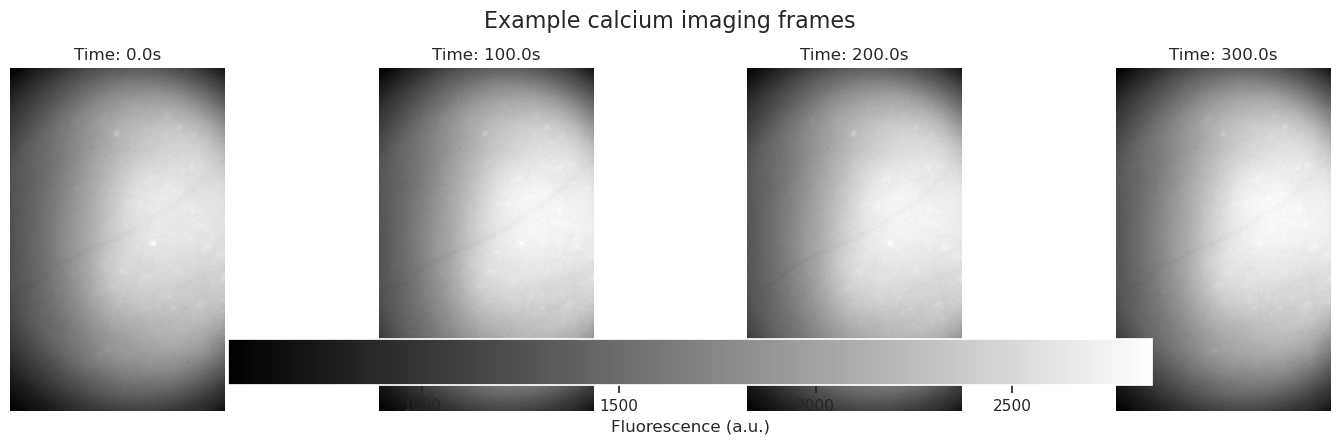

In [8]:
# Load a few example frames - we'll take frames at different time points
# Note: We're only loading a small subset of the data to avoid memory issues
frame_indices = [0, 1000, 2000, 3000]
example_frames = [ophys.data[i] for i in frame_indices]

# Create a figure to display the frames
fig, axes = plt.subplots(1, len(example_frames), figsize=(16, 4))
for i, (frame, ax) in enumerate(zip(example_frames, axes)):
    im = ax.imshow(frame, cmap='gray')
    time_point = frame_indices[i] / ophys.rate
    ax.set_title(f"Time: {time_point:.1f}s")
    ax.axis('off')
    
plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.01, shrink=0.8, 
             label='Fluorescence (a.u.)')
plt.tight_layout()
plt.suptitle('Example calcium imaging frames', fontsize=16, y=1.05)
plt.show()

### Exploring segmented ROIs

The NWB file contains information about ROIs (Regions of Interest) that have been identified in the imaging data. These ROIs typically correspond to individual neurons. Let's examine the ROI data.

In [9]:
# Access the ROI data
image_seg = nwb.processing["ophys"].data_interfaces["ImageSegmentation"]
plane_seg = image_seg.plane_segmentations["PlaneSegmentation"]

# Get the number of ROIs
n_rois = len(plane_seg.id.data[:])
print(f"Number of ROIs: {n_rois}")

Number of ROIs: 40


Let's visualize the ROI masks to see where the identified neurons are located within the field of view.

First ROI mask shape: (292, 179)


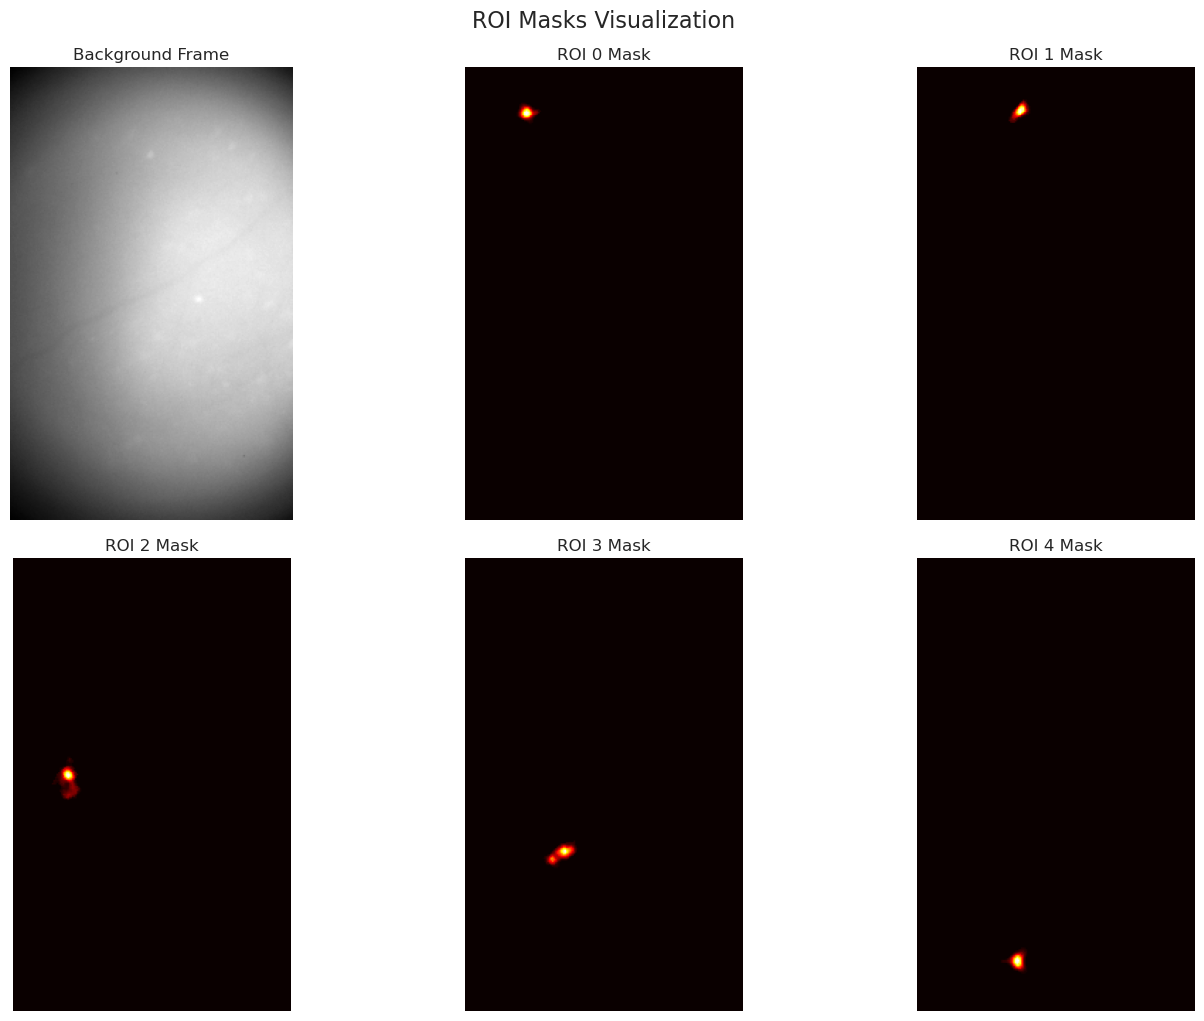

In [10]:
# Let's check the dimensions of the first ROI mask to understand its structure
first_mask = plane_seg.image_mask.data[0]
print(f"First ROI mask shape: {first_mask.shape}")

# Create a figure to visualize the first few ROI masks
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Normalize background frame for display
background_frame = ophys.data[0]
background_normalized = (background_frame - background_frame.min()) / (background_frame.max() - background_frame.min())

# Show background frame in first subplot
axes[0].imshow(background_normalized, cmap='gray')
axes[0].set_title('Background Frame', fontsize=12)
axes[0].axis('off')

# Show individual ROI masks in subsequent subplots
for i in range(1, min(6, n_rois+1)):
    if i <= n_rois:
        mask = plane_seg.image_mask.data[i-1]  # No need to reshape, it's already 2D
        axes[i].imshow(mask, cmap='hot')
        axes[i].set_title(f'ROI {i-1} Mask', fontsize=12)
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle('ROI Masks Visualization', fontsize=16, y=1.02)
plt.show()

### Fluorescence traces

Now let's look at the fluorescence traces for some of the ROIs. These traces show the calcium activity of individual neurons over time.

In [11]:
# Access the fluorescence data
fluorescence = nwb.processing["ophys"].data_interfaces["Fluorescence"]
roi_response_series = fluorescence.roi_response_series["RoiResponseSeries"]

print(f"Fluorescence data dimensions: {roi_response_series.data.shape}")
print(f"Data type: {roi_response_series.data.dtype}")
print(f"Sampling rate: {roi_response_series.rate} Hz")
print(f"Unit: {roi_response_series.unit}")

Fluorescence data dimensions: (9041, 40)
Data type: float32
Sampling rate: 10.0 Hz
Unit: fluorescence


Let's plot the fluorescence traces for a few example ROIs to visualize neuronal activity patterns.

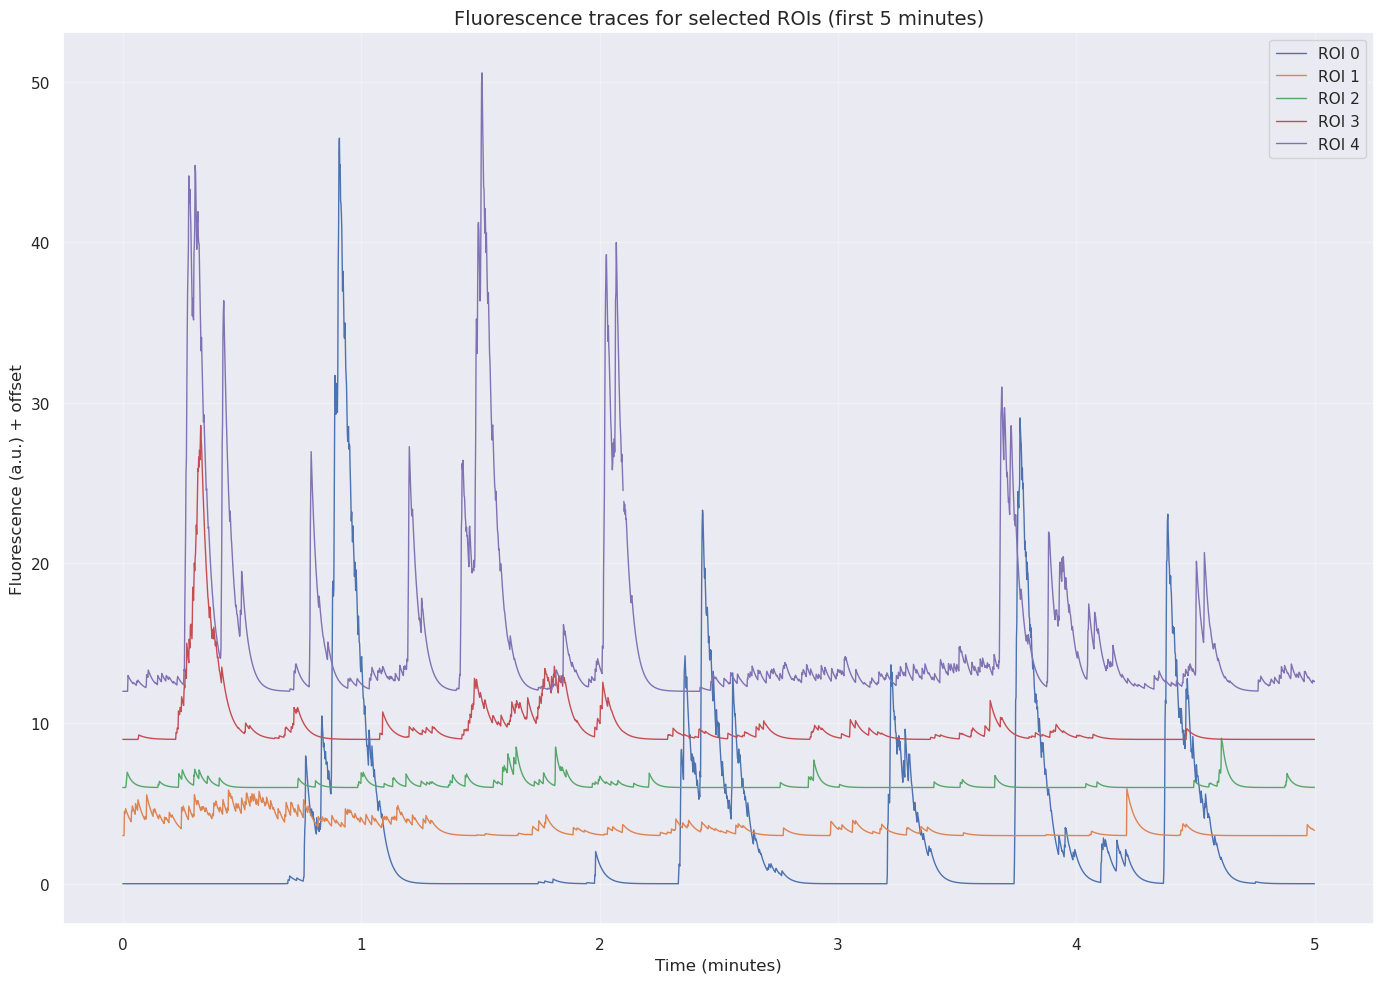

In [12]:
# Select a few ROIs to visualize
roi_indices = list(range(5))  # First 5 ROIs

# Calculate the time axis
time_axis = np.arange(roi_response_series.data.shape[0]) / roi_response_series.rate
time_axis_minutes = time_axis / 60  # Convert to minutes for better visualization

# Create a figure for plotting
plt.figure(figsize=(14, 10))

# Plot each selected ROI's fluorescence trace
for i, roi_idx in enumerate(roi_indices):
    # Extract the fluorescence trace for this ROI (limiting to first 5 minutes for clarity)
    time_limit_idx = int(5 * 60 * roi_response_series.rate)  # 5 minutes worth of data points
    trace = roi_response_series.data[:time_limit_idx, roi_idx]
    
    # Plot with vertical offset for clarity
    offset = i * 3  # Offset each trace to avoid overlap
    plt.plot(time_axis_minutes[:time_limit_idx], trace + offset, 
             label=f'ROI {roi_idx}', linewidth=1)

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Fluorescence (a.u.) + offset', fontsize=12)
plt.title('Fluorescence traces for selected ROIs (first 5 minutes)', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Event detection

The dataset also includes event amplitude data, which represents detected calcium transients (likely corresponding to neuronal spiking events). Let's explore this data.

In [13]:
# Access the event amplitude data
event_amplitude = nwb.processing["ophys"].data_interfaces["EventAmplitude"]

print(f"Event amplitude data dimensions: {event_amplitude.data.shape}")
print(f"Data type: {event_amplitude.data.dtype}")
print(f"Sampling rate: {event_amplitude.rate} Hz")
print(f"Unit: {event_amplitude.unit}")

Event amplitude data dimensions: (9041, 40)
Data type: float64
Sampling rate: 10.003730030174271 Hz
Unit: fluorescence


Let's compare the fluorescence traces with the detected events for a few ROIs.

No clear events found, plotting raw event data


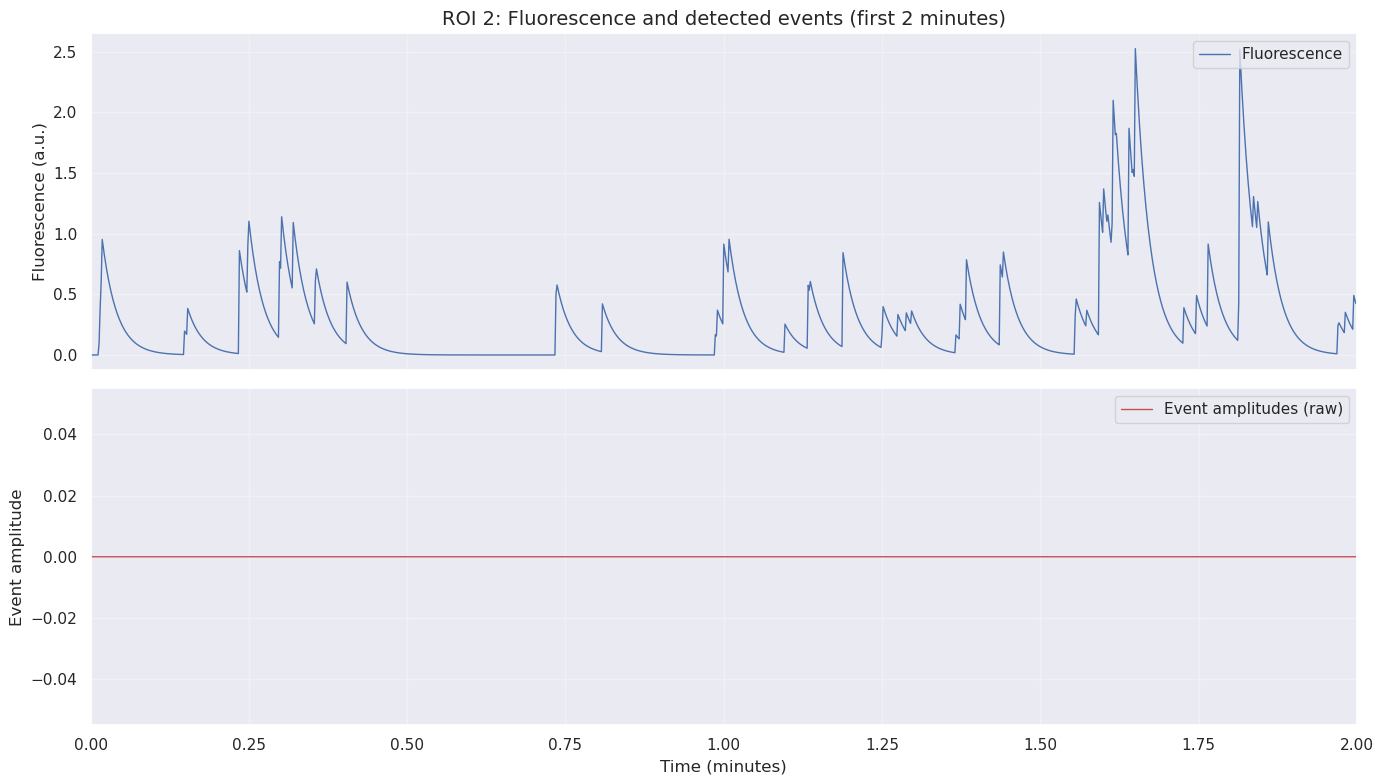

In [14]:
# Select a single ROI to visualize in detail
roi_idx = 2  # Using ROI #2 as an example

# Calculate time axis
time_axis = np.arange(roi_response_series.data.shape[0]) / roi_response_series.rate
time_axis_minutes = time_axis / 60  # Convert to minutes

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# First subplot: Fluorescence trace
# We'll limit to just the first 2 minutes for clearer visualization
time_limit_idx = int(2 * 60 * roi_response_series.rate)  # 2 minutes
time_limit_minutes = 2  # 2 minutes

# Plot fluorescence trace
trace = roi_response_series.data[:time_limit_idx, roi_idx]
ax1.plot(time_axis_minutes[:time_limit_idx], trace, 'b-', linewidth=1, 
         label='Fluorescence')
ax1.set_ylabel('Fluorescence (a.u.)', fontsize=12)
ax1.set_title(f'ROI {roi_idx}: Fluorescence and detected events (first 2 minutes)', 
              fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right')

# Second subplot: Event amplitude
events = event_amplitude.data[:time_limit_idx, roi_idx]

# Try different thresholds until we find events
for threshold in [0.0, 0.01, 0.05, 0.1]:
    event_mask = events > threshold
    if np.any(event_mask):
        print(f"Found events above threshold {threshold}")
        event_times = time_axis_minutes[:time_limit_idx][event_mask]
        event_amplitudes = events[event_mask]
        
        # Plot events as stem plot
        ax2.stem(event_times, event_amplitudes, 'r-', markerfmt='ro', basefmt=' ', 
                label=f'Events (threshold={threshold})')
        break
else:
    # If no events found with any threshold, just plot the raw events data
    print("No clear events found, plotting raw event data")
    ax2.plot(time_axis_minutes[:time_limit_idx], events, 'r-', linewidth=1, 
            label='Event amplitudes (raw)')

ax2.set_xlabel('Time (minutes)', fontsize=12)
ax2.set_ylabel('Event amplitude', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

# Set x-axis limits
ax1.set_xlim(0, time_limit_minutes)
ax2.set_xlim(0, time_limit_minutes)

plt.tight_layout()
plt.show()

### Analyzing correlations between ROIs

Let's investigate the relationship between different ROIs by calculating the correlation of their fluorescence activity.

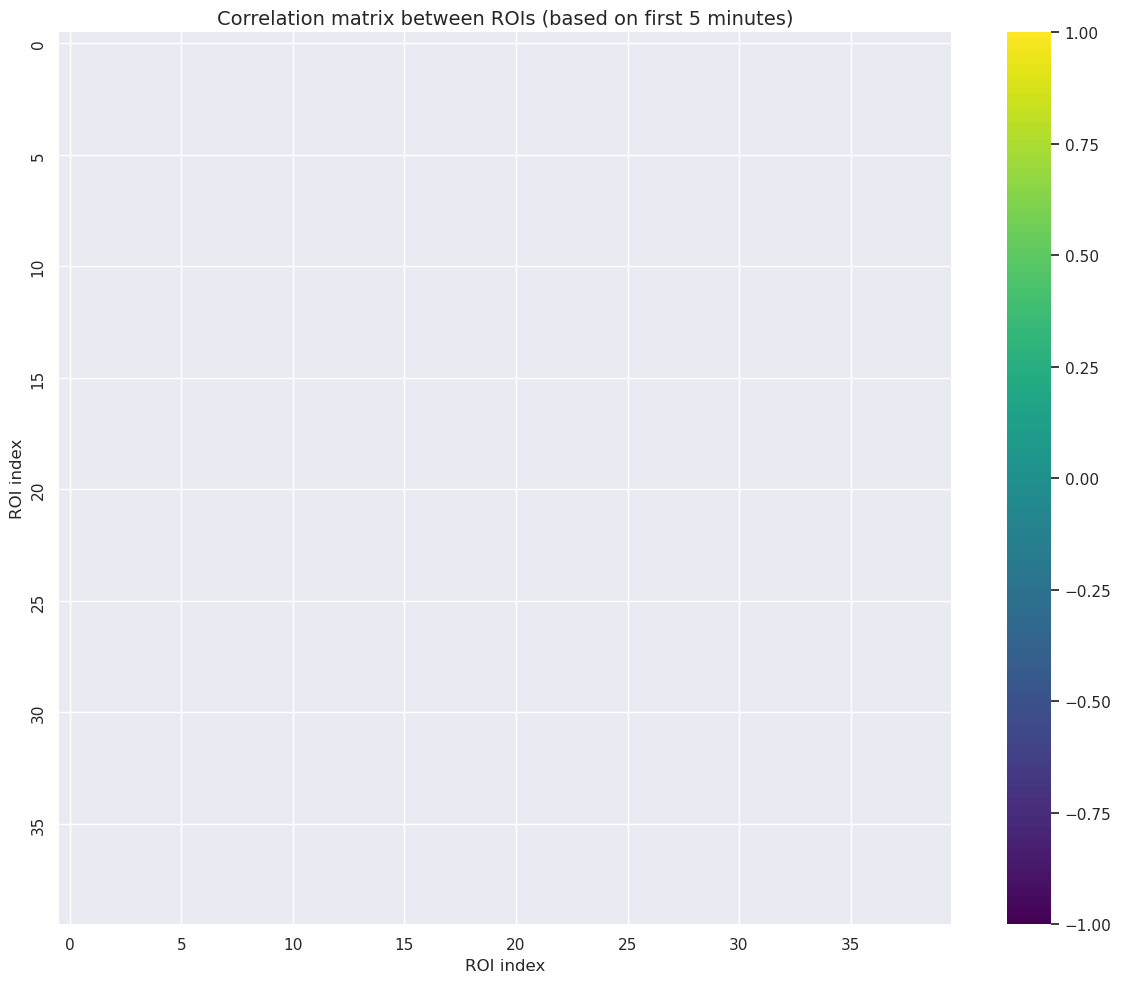

Number of ROI pairs with correlation > 0.7: 0
Number of ROI pairs with correlation > 0.6: 0
Number of ROI pairs with correlation > 0.5: 0
Number of ROI pairs with correlation > 0.4: 0
No highly correlated pairs found with the thresholds tested.


In [15]:
# Calculate correlation matrix between ROIs using fluorescence data
# To keep computation manageable, we'll:
# 1. Use a subset of the time series (first 5 minutes)
# 2. Downsample by taking every 10th point

# Prepare data
time_limit_idx = int(5 * 60 * roi_response_series.rate)  # 5 minutes of data
downsample_factor = 10
downsampled_data = roi_response_series.data[:time_limit_idx:downsample_factor, :]

# Calculate correlation matrix
correlation_matrix = np.corrcoef(downsampled_data.T)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='viridis', vmin=-1, vmax=1, 
            xticklabels=5, yticklabels=5)
plt.title('Correlation matrix between ROIs (based on first 5 minutes)', fontsize=14)
plt.xlabel('ROI index')
plt.ylabel('ROI index')
plt.tight_layout()
plt.show()

# Find correlated pairs - try different thresholds if needed
threshold_to_try = [0.7, 0.6, 0.5, 0.4]
high_corr_pairs = []

for threshold in threshold_to_try:
    # Make a copy to avoid modifying the original
    corr_mat_copy = correlation_matrix.copy()
    np.fill_diagonal(corr_mat_copy, 0)  # Ignore self-correlations
    high_corr_indices = np.where(corr_mat_copy > threshold)
    high_corr_pairs = list(zip(high_corr_indices[0], high_corr_indices[1]))
    
    print(f"Number of ROI pairs with correlation > {threshold}: {len(high_corr_pairs)}")
    
    # If we found at least one pair, break the loop
    if high_corr_pairs:
        if len(high_corr_pairs) > 5:
            print("Top 5 most correlated pairs:")
            # Sort by correlation value
            sorted_pairs = sorted([(i, j, correlation_matrix[i, j]) 
                                  for i, j in high_corr_pairs], 
                                 key=lambda x: x[2], reverse=True)
            for i, j, corr in sorted_pairs[:5]:
                print(f"ROI {i} -- ROI {j}: r = {corr:.3f}")
        else:
            print("Correlated pairs:")
            for i, j in high_corr_pairs:
                print(f"ROI {i} -- ROI {j}: r = {correlation_matrix[i, j]:.3f}")
        break
else:
    print("No highly correlated pairs found with the thresholds tested.")

### Visualizing highly correlated ROI pairs

Let's visualize a few highly correlated ROI pairs to observe their spatial relationship and activity patterns.

In [16]:
# This code will only run if we found highly correlated pairs
if high_corr_pairs:
    # Take the first pair for visualization
    roi_pair = high_corr_pairs[0]
    roi1_idx, roi2_idx = roi_pair
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]})
    
    # 1. Visualize the ROI masks (top subplot)
    # Create a figure with two panels side by side
    gs = plt.GridSpec(1, 2)
    
    # First panel - first ROI mask
    ax1 = plt.subplot(gs[0, 0])
    mask1 = plane_seg.image_mask.data[roi1_idx]  # No need to reshape, already 2D
    ax1.imshow(mask1, cmap='hot')
    ax1.set_title(f'ROI {roi1_idx} Mask', fontsize=12)
    ax1.axis('off')
    
    # Second panel - second ROI mask
    ax2 = plt.subplot(gs[0, 1])
    mask2 = plane_seg.image_mask.data[roi2_idx]  # No need to reshape, already 2D
    ax2.imshow(mask2, cmap='hot')
    ax2.set_title(f'ROI {roi2_idx} Mask', fontsize=12)
    ax2.axis('off')
    
    plt.suptitle(f'Correlated ROI pair (r = {correlation_matrix[roi1_idx, roi2_idx]:.3f})', 
                fontsize=14)
    
    # 2. Plot fluorescence traces (bottom subplot)
    # Use a shorter time period for clarity (first 2 minutes)
    time_limit_idx = int(2 * 60 * roi_response_series.rate)
    time_subset = time_axis_minutes[:time_limit_idx]
    
    # Get traces for both ROIs
    trace1 = roi_response_series.data[:time_limit_idx, roi1_idx]
    trace2 = roi_response_series.data[:time_limit_idx, roi2_idx]
    
    # Normalize traces for better comparison
    trace1_norm = (trace1 - trace1.min()) / (trace1.max() - trace1.min())
    trace2_norm = (trace2 - trace2.min()) / (trace2.max() - trace2.min())
    
    # Create a new axis for the fluorescence traces
    ax3 = plt.subplot(2, 1, 2)
    ax3.plot(time_subset, trace1_norm, 'r-', label=f'ROI {roi1_idx}')
    ax3.plot(time_subset, trace2_norm, 'g-', label=f'ROI {roi2_idx}')
    ax3.set_xlabel('Time (minutes)', fontsize=12)
    ax3.set_ylabel('Normalized fluorescence', fontsize=12)
    ax3.legend(loc='upper right')
    ax3.set_title('Fluorescence traces (first 2 minutes)', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No highly correlated ROI pairs found.")

No highly correlated ROI pairs found.


## Summary and Future Directions

In this notebook, we've explored calcium imaging data from Dandiset 001174, which contains recordings from the supplementary motor area (SMA) and primary motor area (M1) of macaques during arm reaching tasks.

### Key findings from our exploration:

1. The dataset contains calcium imaging recordings from multiple macaque subjects (F, Q, U, and V)
2. We focused on analyzing data from subject Q, session 20220915T133954
3. The recording contains one-photon calcium imaging data at 10 Hz with 40 identified ROIs (neurons)
4. We visualized and analyzed:
   - Raw calcium imaging frames
   - ROI mask locations
   - Fluorescence traces from individual neurons
   - Detected calcium events (potential neural activity)
   - Correlations between neurons

### Potential future analyses:

1. **Behavioral correlations**: Analyze how neural activity relates to specific arm reaching movements
2. **Population dynamics**: Perform dimensionality reduction (e.g., PCA, t-SNE) to identify population-level patterns
3. **Temporal patterns**: Analyze the temporal sequence of activation patterns across neurons
4. **Cross-session comparison**: Compare neural activity patterns across different recording sessions
5. **Cross-subject comparison**: Compare activity patterns between different subjects
6. **Network analysis**: Construct functional connectivity networks based on correlations between neurons

This dataset provides valuable insights into motor cortex activity in non-human primates, which has implications for understanding human motor control and potentially for developing treatments for movement disorders.